In [ ]:
pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 11.3 MB/s eta 0:00:00


# Model implementation with imbalanced data


In [ ]:
pip install imbalanced-learn

In [ ]:
import pandas as pd
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, f1_score
from imblearn.combine import SMOTEENN
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv("df_train.csv")

X = df.drop(columns='class')
y = df['class']

for col in X.select_dtypes(include=['object', 'category']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Apply SMOTEENN
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)

# Create CatBoost Pool
train_pool = Pool(X_resampled, y_resampled)
test_pool = Pool(X_test, y_test)

model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    eval_metric='AUC',
    verbose=100,
    random_state=42
)

model.fit(train_pool, eval_set=test_pool)

y_proba = model.predict_proba(X_test)[:, 1]
threshold = 0.3
y_pred = (y_proba >= threshold).astype(int)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))


0:	test: 0.9973898	best: 0.9973898 (0)	total: 113ms	remaining: 56.3s
100:	test: 0.9983952	best: 0.9987650 (3)	total: 4.33s	remaining: 17.1s
200:	test: 0.9983952	best: 0.9987650 (3)	total: 7.13s	remaining: 10.6s
300:	test: 0.9983952	best: 0.9987650 (3)	total: 10s	remaining: 6.63s
400:	test: 0.9983952	best: 0.9987650 (3)	total: 13.8s	remaining: 3.41s
499:	test: 0.9983952	best: 0.9987650 (3)	total: 17.4s	remaining: 0us

bestTest = 0.9987650181
bestIteration = 3

Shrink model to first 4 iterations.
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     27393
           1       0.95      1.00      0.98      2830

    accuracy                           1.00     30223
   macro avg       0.98      1.00      0.99     30223
weighted avg       1.00      1.00      1.00     30223

ROC AUC Score: 0.9987650181193282
Precision: 0.9519004372687521
Recall: 1.0
F1 Score: 0.975357573668792


# Model Evaluation with imbalanced data

In [ ]:
#Basic Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    precision_recall_curve
)
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(test_pool)
y_proba = model.predict_proba(test_pool)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

Accuracy: 0.9952685041193793
Precision: 0.9519004372687521
Recall: 1.0
F1 Score: 0.975357573668792
ROC AUC Score: 0.9987650181193282


In [ ]:
#Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     27393
           1       0.95      1.00      0.98      2830

    accuracy                           1.00     30223
   macro avg       0.98      1.00      0.99     30223
weighted avg       1.00      1.00      1.00     30223



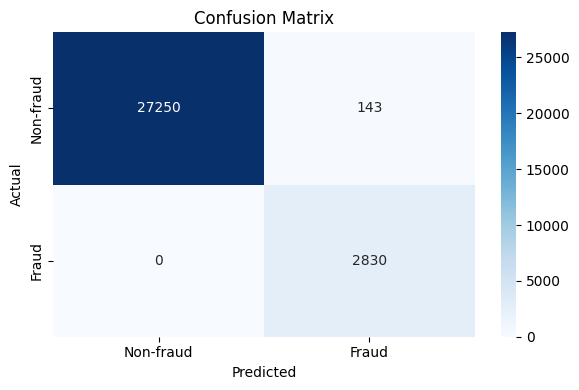

In [ ]:
#Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-fraud', 'Fraud'], yticklabels=['Non-fraud', 'Fraud'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

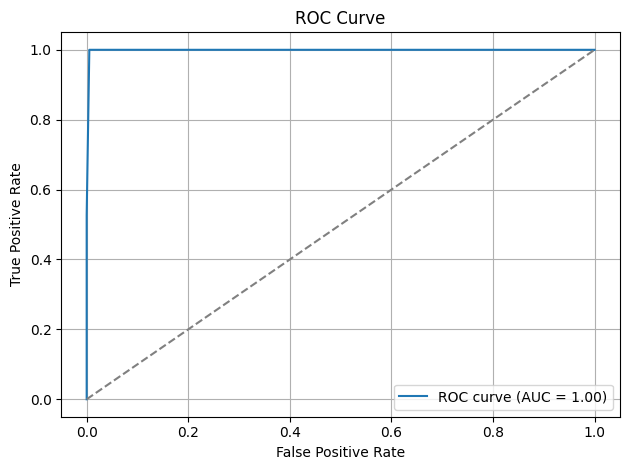

In [ ]:
#ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc_score(y_test, y_proba):.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

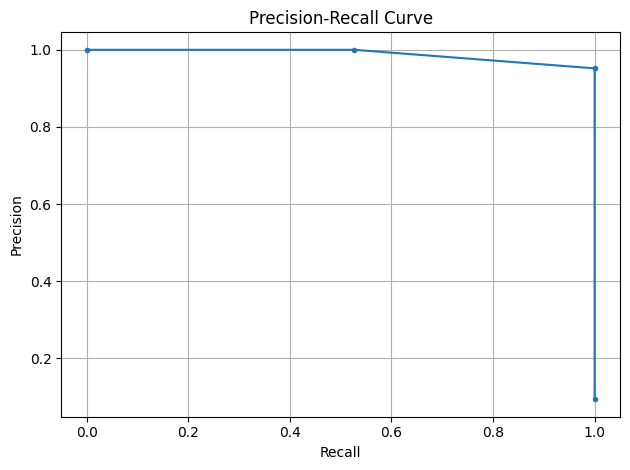

In [ ]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure()
plt.plot(recall, precision, marker='.')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.tight_layout()
plt.show()

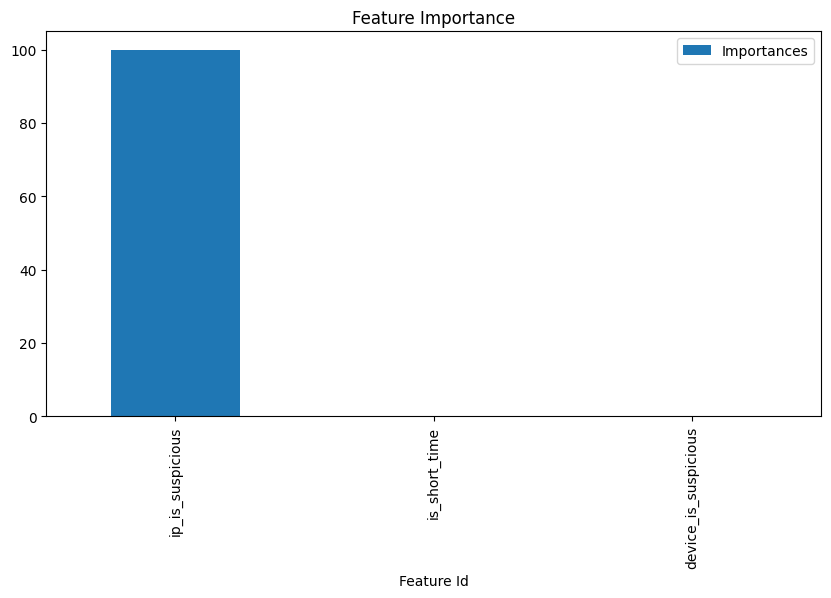

In [ ]:
#Feature Importance Plot
feature_importance = model.get_feature_importance(prettified=True)
feature_importance.plot(x='Feature Id', y='Importances', kind='bar', figsize=(10, 5))
plt.title('Feature Importance')
plt.show()


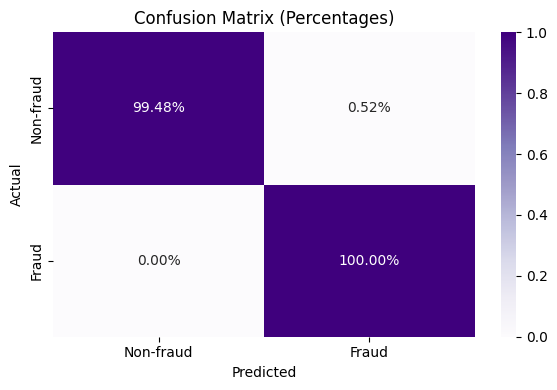

In [ ]:
#Confusion Matrix with Percentages
import numpy as np

conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_percent, annot=True, fmt=".2%", cmap='Purples',
            xticklabels=['Non-fraud', 'Fraud'], yticklabels=['Non-fraud', 'Fraud'])
plt.title('Confusion Matrix (Percentages)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


In [ ]:
#KS Statistic (Kolmogorov-Smirnov Test)
from scipy.stats import ks_2samp

ks_stat, p_value = ks_2samp(y_proba[y_test == 0], y_proba[y_test == 1])
print(f"KS Statistic: {ks_stat:.4f}, p-value: {p_value:.4f}")


KS Statistic: 0.9948, p-value: 0.0000


In [ ]:
pip install shap


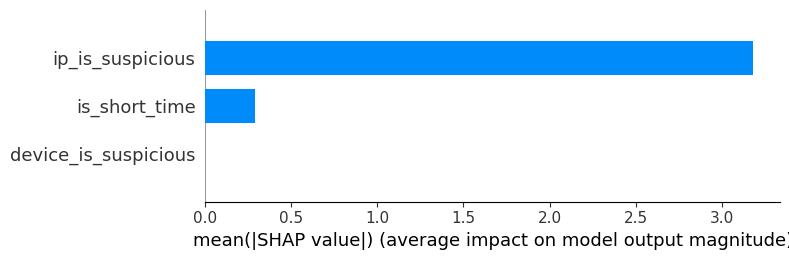

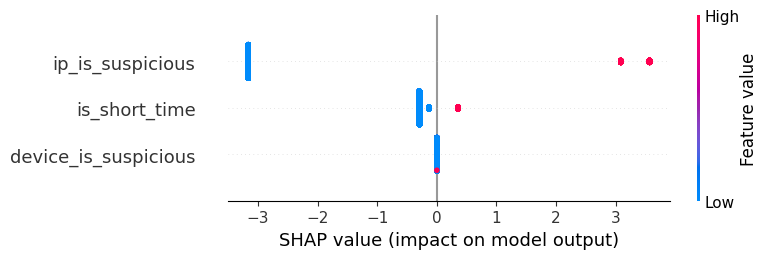

In [ ]:
#Shap Values
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test)


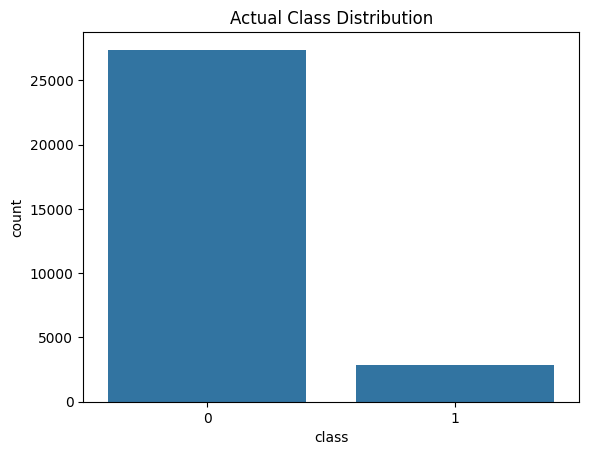

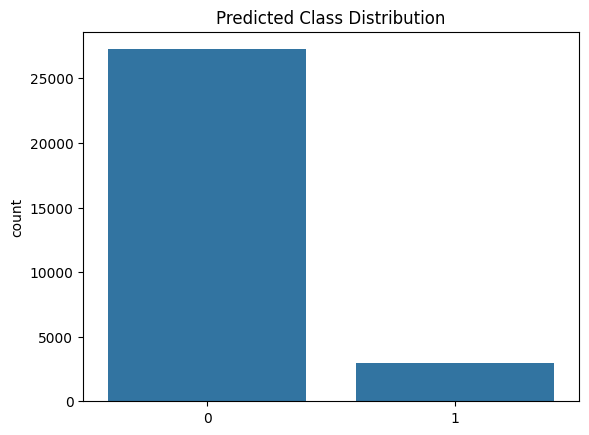

In [ ]:
# Original class distribution
sns.countplot(x=y_test)
plt.title("Actual Class Distribution")
plt.show()

# Predicted class distribution
sns.countplot(x=y_pred)
plt.title("Predicted Class Distribution")
plt.show()


# Model implementation with balanced data

In [ ]:
import pandas as pd
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, f1_score

df = pd.read_csv("df_train_balanced.csv")

X = df.drop(columns='class')
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

fraud_weight = (y == 0).sum() / (y == 1).sum()

# Create CatBoost Pool
train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test, y_test)

# Train CatBoost model
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    eval_metric='AUC',
    class_weights=[1, fraud_weight],
    verbose=100,
    random_state=42
)

model.fit(train_pool, eval_set=test_pool)

y_proba = model.predict_proba(X_test)[:, 1]
threshold = 0.3
y_pred = (y_proba >= threshold).astype(int)

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))


0:	test: 0.9999270	best: 0.9999270 (0)	total: 112ms	remaining: 55.9s
100:	test: 1.0000000	best: 1.0000000 (3)	total: 7.5s	remaining: 29.6s
200:	test: 1.0000000	best: 1.0000000 (3)	total: 11s	remaining: 16.4s
300:	test: 1.0000000	best: 1.0000000 (3)	total: 14.7s	remaining: 9.71s
400:	test: 1.0000000	best: 1.0000000 (3)	total: 19.7s	remaining: 4.87s
499:	test: 1.0000000	best: 1.0000000 (3)	total: 23.9s	remaining: 0us

bestTest = 1
bestIteration = 3

Shrink model to first 4 iterations.
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     27247
           1       1.00      1.00      1.00     27392

    accuracy                           1.00     54639
   macro avg       1.00      1.00      1.00     54639
weighted avg       1.00      1.00      1.00     54639

ROC AUC Score: 1.0
Precision: 1.0
Recall: 0.9998539719626168
F1 Score: 0.9999269806498722


# Model evaluation with balanced data

In [ ]:
#Basic Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    precision_recall_curve
)
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(test_pool)
y_proba = model.predict_proba(test_pool)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

Accuracy: 0.9999267922180127
Precision: 1.0
Recall: 0.9998539719626168
F1 Score: 0.9999269806498722
ROC AUC Score: 1.0


In [ ]:
#Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     27247
           1       1.00      1.00      1.00     27392

    accuracy                           1.00     54639
   macro avg       1.00      1.00      1.00     54639
weighted avg       1.00      1.00      1.00     54639



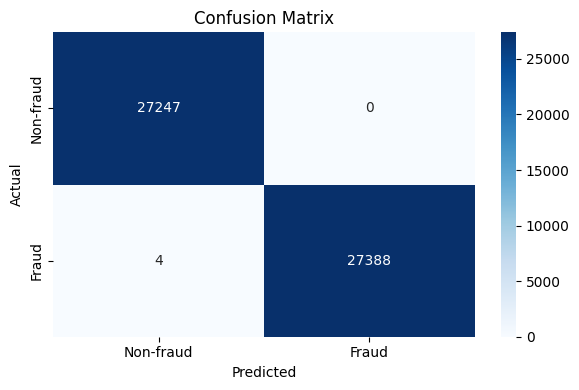

In [ ]:
#Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-fraud', 'Fraud'], yticklabels=['Non-fraud', 'Fraud'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

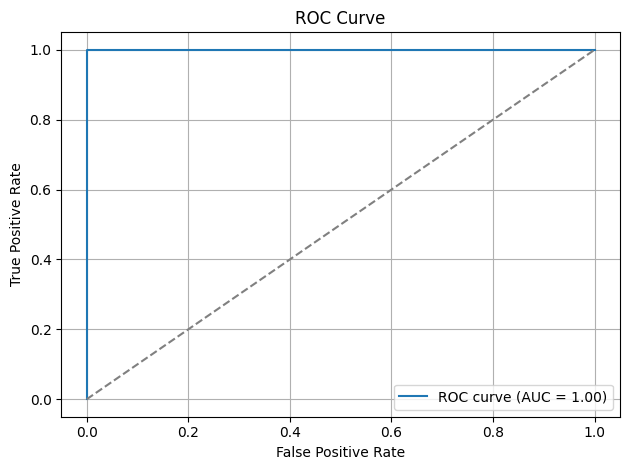

In [ ]:
#ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc_score(y_test, y_proba):.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

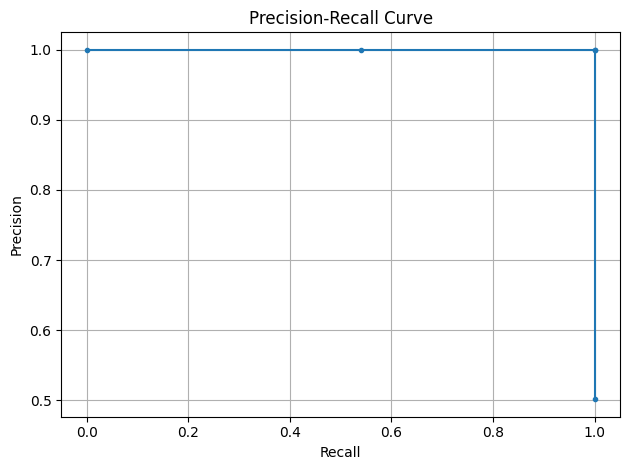

In [ ]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure()
plt.plot(recall, precision, marker='.')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.tight_layout()
plt.show()

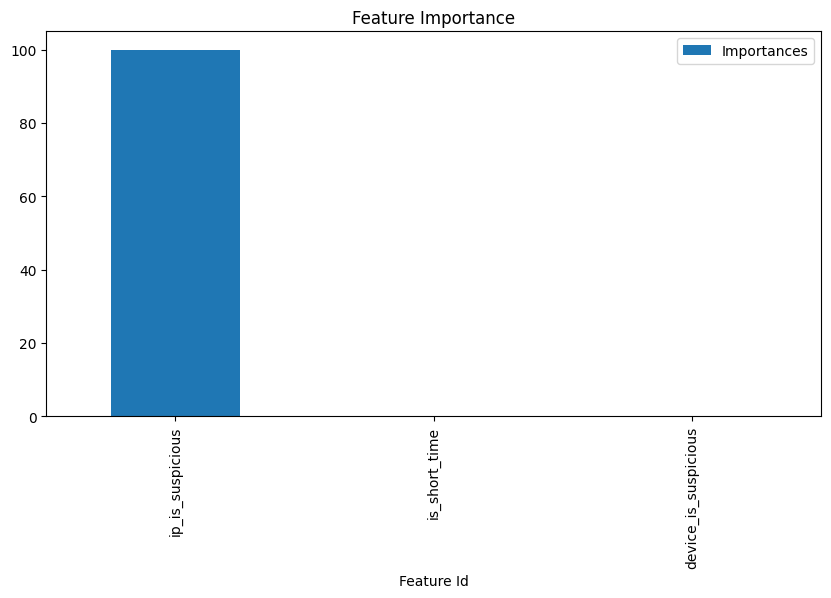

In [ ]:
#Feature Importance Plot
feature_importance = model.get_feature_importance(prettified=True)
feature_importance.plot(x='Feature Id', y='Importances', kind='bar', figsize=(10, 5))
plt.title('Feature Importance')
plt.show()


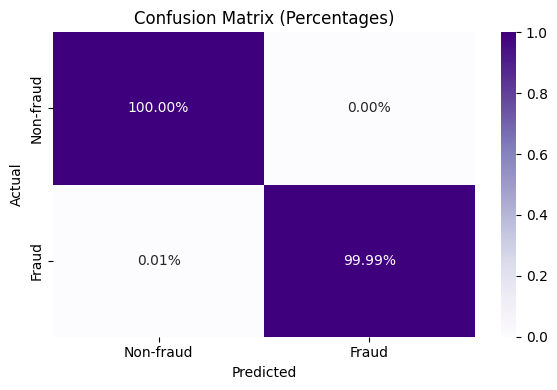

In [ ]:
#Confusion Matrix with Percentages
import numpy as np

conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_percent, annot=True, fmt=".2%", cmap='Purples',
            xticklabels=['Non-fraud', 'Fraud'], yticklabels=['Non-fraud', 'Fraud'])
plt.title('Confusion Matrix (Percentages)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


In [ ]:
#KS Statistic (Kolmogorov-Smirnov Test)
from scipy.stats import ks_2samp

ks_stat, p_value = ks_2samp(y_proba[y_test == 0], y_proba[y_test == 1])
print(f"KS Statistic: {ks_stat:.4f}, p-value: {p_value:.4f}")


KS Statistic: 1.0000, p-value: 0.0000


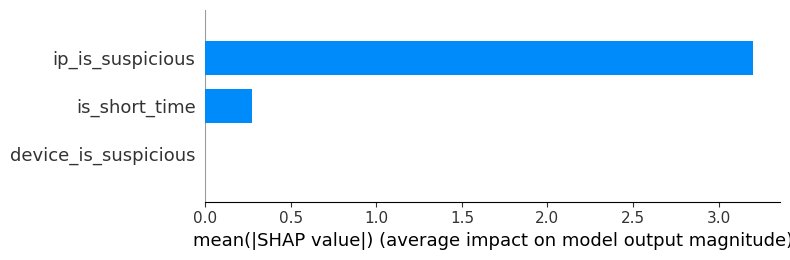

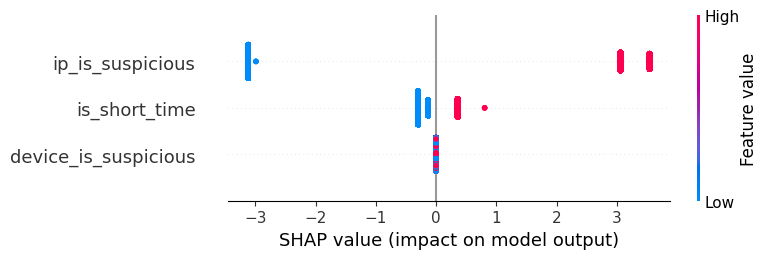

In [ ]:
#Shap Values
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test)


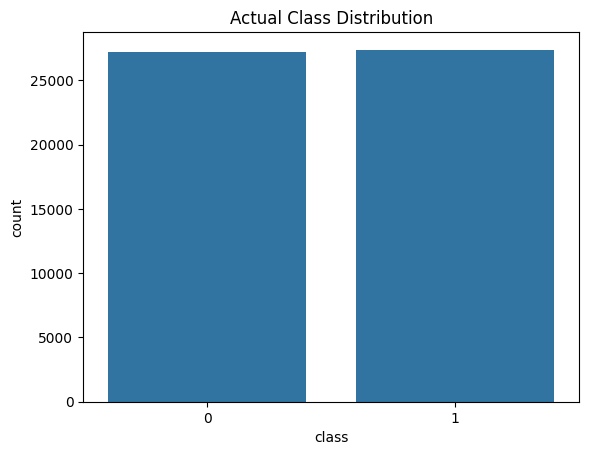

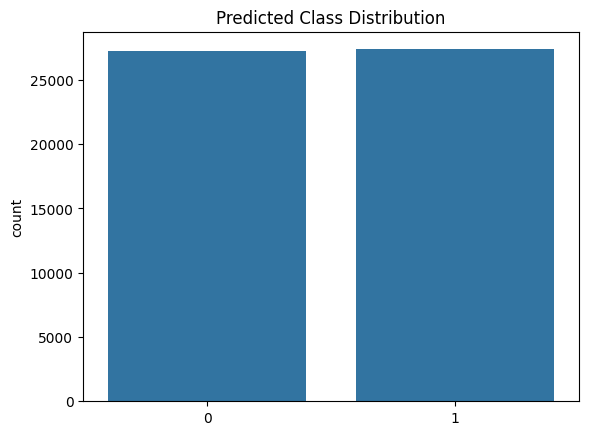

In [ ]:
# Original class distribution
sns.countplot(x=y_test)
plt.title("Actual Class Distribution")
plt.show()

# Predicted class distribution
sns.countplot(x=y_pred)
plt.title("Predicted Class Distribution")
plt.show()
